### 运用湖北省疫情数据建立SIR模型

这里我们用湖北省的疫情数据举例，运用SIR模型进行模拟。基于之前的讲解，需要输入odeint()函数的参数：微分方程、初始值、t以及微分方程的相关参数，我们首先需要定义我们刚刚建立好的SIR微分方程：

In [11]:
#   我们定义函数的名称为SIR
def SIR(y,t,beta,gamma):
    S,I,R = y
    dSdt = -S*(I/(S+I+R))*beta
    dIdt = beta*S*I/(S+I+R)-gamma*I
    dRdt = gamma*I
    return [dSdt,dIdt,dRdt]

通过搜索，我们可以知道湖北省的人口数量大约为5800万，并且通过新闻，我们可以知道1月25日时总确诊人数是239人，累计治愈与死亡人数一共为31人。因为在实际情形中，治愈与死亡案例都代表这个病人以后不会再将疾病传染给他人，所以这里我们将治愈与死亡人数合计为模型中的恢复人数。



In [12]:
# 设置人群总人数为N
N = 58000000
# 设置初始时的感染人数I0为239
I0 = 239
# 设置初始时的恢复人数R0为31
R0 = 31
# 所以，初始易感者人群人数 = 总人数 - 初始感染人数 - 初始治愈人数
S0 = N - I0 - R0
# 设置初始值
y0 = [S0, I0, R0]

再然后，我们确定数组t以及在微分方程中的两个参数 β 与 γ 的值。我们首先确定我们估计从初始值开始疫情发展60天的状态。通过搜索一些关于新冠疫情的研究报告，我们可以看到这里 β 的估计值约等于0.125~0.25，而 γ的估计值约等于0.05。这也就是说，之前在湖北省疫情期间，新冠病情的治愈周期大约为20天。我们先设置 β 的值等于0.125。

In [13]:
import numpy as np

# 设置估计疫情的时间跨度为150天
t = np.linspace(1,150,150)

# 设置beta值等于0.125
beta = 0.125

# 设置gamma的值等于0.05
gamma = 0.05

接下来我们就开始运用```scipy.integrate.odeint()```函数，获得微分方程组的解的函数值。

In [14]:
from scipy.integrate import odeint

# 求解
solution = odeint(SIR, y0, t, args = (beta, gamma))

这样，我们就获得了150天内对每一天的S、I和R的估计值，通过输出```solution```，我们可以对结果进行查看：

In [15]:
# 要求Python的所有输出不用科学计数法表示
np.set_printoptions(suppress=True)

# 输出结果的前四行进行查看
solution[0:4,0:3]

array([[57999730.        ,      239.        ,       31.        ],
       [57999698.97630736,      257.6141545 ,       43.40953815],
       [57999665.53640249,      277.67802415,       56.78557338],
       [57999629.49210659,      299.30451407,       71.20337936]])

我们可以很明显的发现，在1月25日至27日时，三类人群的人数还是在不断上升的，但是用数字来对结果进行观察还是不够直观，下一步，我们尝试用绘图的方式，来将SIR模型的预测结果更清晰的展现出来：

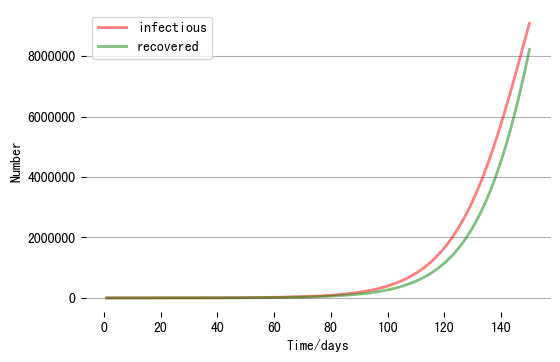

In [16]:
import matplotlib.pyplot as plt
# 绘图展示
%matplotlib inline

fig, ax = plt.subplots(facecolor='w', dpi=100)

for data, color, label_name in zip([solution[:,1], solution[:,2]], ['r', 'g'], ['infectious', 'recovered']):
    ax.plot(t, data, color, alpha=0.5, lw=2, label=label_name)

ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)

通过上边这幅图我们可以很明显的发现在疫情初始值的60天以内，疫情还是处在很明显的上升期的。我们还无法观察到疫情发展的全貌，下面我们将尝试拉长预测与观察的周期，尝试查看完整的疫情发展的形势。

In [17]:
# 观察的时间周期扩充为360天
t = np.linspace(1,360,360)

solution = odeint(SIR, y0, t, args = (beta, gamma))

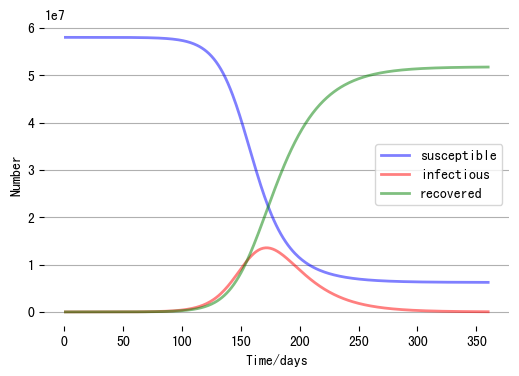

In [18]:
fig, ax = plt.subplots(facecolor='w', dpi=100)

for index, color, label_name in zip(range(3), ['b','r','g'], ['susceptible', 'infectious', 'recovered']):
    ax.plot(t, solution[:, index], color, alpha=0.5, lw=2, label=label_name)

ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
ax.legend()
ax.grid(axis='y')
plt.box(False)

这样我们就可以看见，在我们的估计中疫情大约会在160天左右达到峰值，随后开始下降，在峰值的感染者人数也达到了将近1000万人。通过对比现实中的情形，我们也知道这与现实中的情形是严重不符的。接下来，我们将一起绘制真实的疫情数据与估计疫情数据的对比图。我们首先导入数据：

In [19]:
import pandas as pd 
# 读入数据
data = pd.read_csv('./alltime_province_2020_03_26.csv')
# 选择数据中关于湖北省的数据
hubei = data[data['name'] == '湖北']

下面我们在数据中选择出每一天的实际感染者人数与恢复者人数：

In [20]:
infectious_real = hubei['total_confirm'] - hubei['total_heal'] - hubei['total_dead']
recovered_real = hubei['total_heal'] + hubei['total_dead']
susceptible_real = N - infectious_real - recovered_real

然后我们需要根据爬取到数据的长度重新确定我们需要观察的时间周期，之后进行绘图：

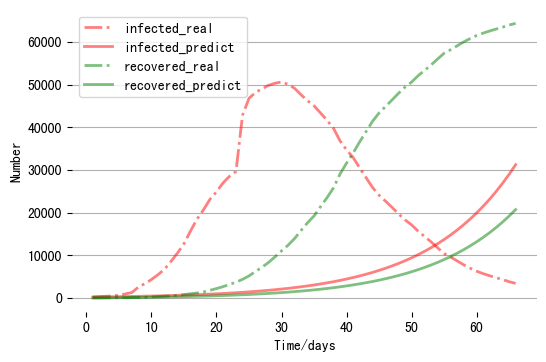

In [21]:
# 确定观察的时间周期
T = len(infectious_real)
# 设置估计疫情的时间跨度为T天
t = np.linspace(1,T,T)
# 估计三种人数的数量
solution = odeint(SIR, y0, t, args = (beta, gamma))
# 绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)
# 绘制估计的I曲线与真实的I曲线
ax.plot(t, infectious_real, 'r-.', alpha=0.5, lw=2, label='infected_real')
ax.plot(t, solution[:,1], 'r', alpha=0.5, lw=2, label='infected_predict')
# 绘制估计的R曲线与真实的R曲线
ax.plot(t, recovered_real, 'g-.', alpha=0.5, lw=2, label='recovered_real')
ax.plot(t, solution[:,2], 'g', alpha=0.5, lw=2, label='recovered_predict')
# 设置横纵座标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
ax.legend()
ax.grid(axis='y')
plt.box(False)

所以，我们可以看见，相较于我们的估计，湖北省的实际感染者人数很早便达到并经过了峰值。并且，实际的治愈与恢复人数也很早便进入了稳定状态。

### 基本再生数 R0

通过上边的分析，我们就可以知道传染病的人群中传播的时候，疫情的发展形势与$\beta$值和$\gamma$值是息息相关的。那么我们还是用湖北省的人口数据举例，查看当没有外界干预的条件下，不同的$\beta$值和$\gamma$值会对疫情造成什么样的变化。

我们设立4组不同的$\beta$值和$\gamma$值进行预测，并对结果进行比较：

||$\beta$|$\gamma$|
|--|:--:|:--:|
|1|0.125|0.05|
|2|0.25|0.05|
|3|0.25|0.1|
|4|0.125|0.1|

在这四组预测中，第一组与我们之前做的预测是相同的。第二组将$\beta$的值扩大了一倍，而$\gamma$值不变，也就是说在第二组估计中，我们设置新冠病毒的传染性变得更强了，但是治愈速率没有改变，也就是说一个患者还是需要花同样长的时间才能康复。在第三组中，我们设置新冠病毒的传染性变得更强的同时，治愈速率也提高了一倍，患者只需要原来一半的时间就可以康复。在第四组中，我们没有对新冠病毒的传染性作出调整，并且设置患者只需要原来一半的情形就可以康复。

下面我们就一起来看一看，在这四种情形下，疫情的形势都将发生怎样的变化。

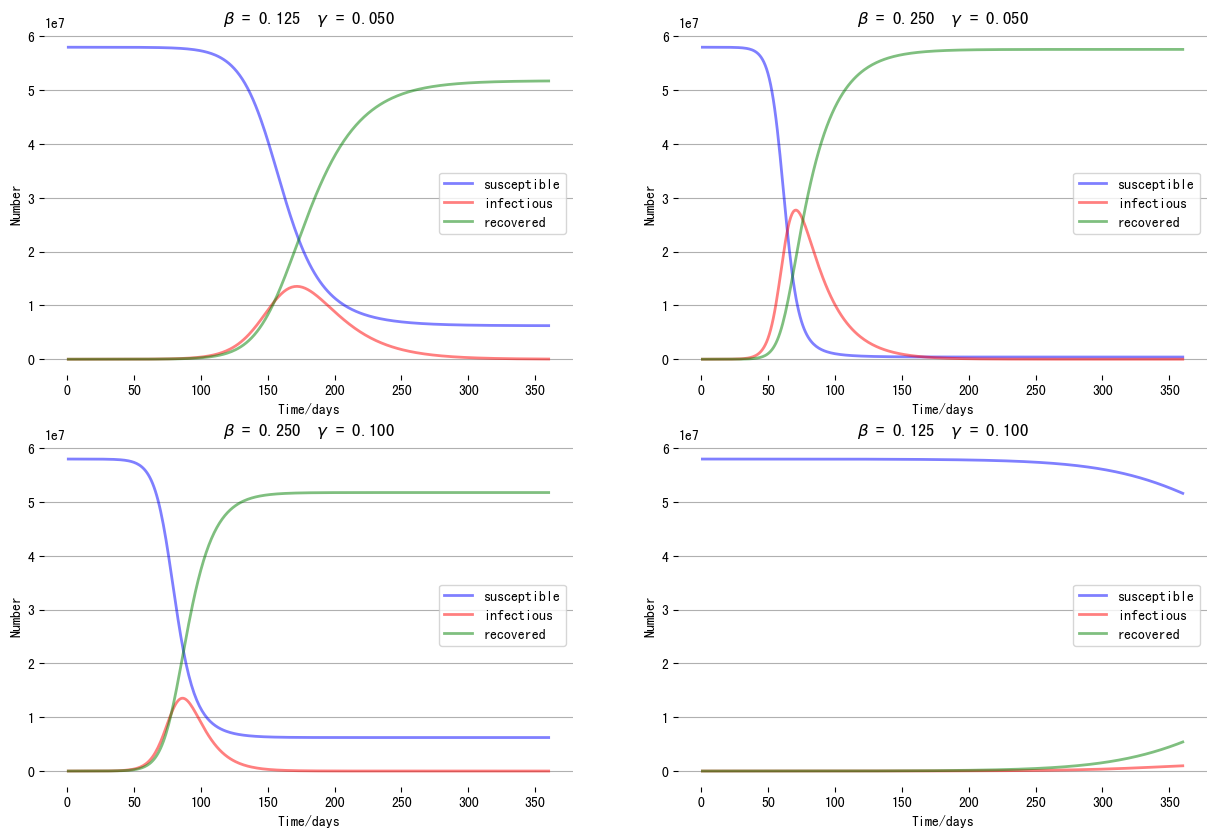

In [22]:
t = np.linspace(1,360,360)
# 设置beta和gamma参数
param_list = [(0.125, 0.05),
             (0.25, 0.05),
             (0.25, 0.1),
             (0.125, 0.1)]
# 预测
solution_list = [odeint(SIR, y0, t, args=item) for item in param_list]
# 绘图
fig = plt.figure(facecolor='w',figsize=(15,10), dpi=100)

for plot_index, solution, params in zip(range(5)[1:], solution_list, param_list):
    
    ax = fig.add_subplot(int('22'+str(plot_index)))
    ax.set_title(r'$\beta$ = %.3f  $\gamma$ = %.3f' % params)
    
    for index, color, label_name in zip(range(3), 
                                        ['b','r','g'],
                                        ['susceptible','infectious','recovered']):
        ax.plot(t, solution[:, index], color, alpha=0.5, lw=2, label=label_name)
    
    ax.set_xlabel('Time/days')
    ax.set_ylabel('Number')
    ax.legend()
    ax.grid(axis='y')
    plt.box(False)

在这4副图中，随着$\beta$值和$\gamma$值的变化，我们对湖北省疫情形势的估计也不同。疫情峰值受$\frac{\beta}{\gamma}$值的影响。

这里我们叫$\frac{\beta}{\gamma}$的值为$R_0$也就是基本再生数。基本再生数（Basic reproduction number）是在流行病学上，指在没有外力介入，同时所有人没有免疫力的情况下，一个感染到某种传染病的人，会把疾病传染给其他多少人的平均数。在有关疫情的新闻播报中，我们时常可以听到有关再生数$R_0$的相关内容，$R_0$的值越高，也就意味着疫情高峰到来时的情形可能越严重。下面的表格中，我们就列出了几种常见传染病的再生数：

||传染病|基本再生数$R_0$|
|--|:--|:--|
|1|SARS冠状病毒（非典型性肺炎）|2~5|
|2|MERS冠状病毒（中东呼吸综合征）|$<1$|
|3|H1N1（猪流感）|1.4~3.8|
|4|COVID-19冠状病毒|1.4~5.5|

对SIR模型的估计也能为我们的防疫措施带来启发，我们会经常在关于疫情防控的说明中，经常会看见类似下图的图片：
![png](http://cookdata.cn/media/note_images/图片1_1586506527456_5d14.jpg)

蓝色峰相较于红色峰到达的时间更晚，并且峰值更小。也就是说在真正的疫情中，蓝色峰将比红色峰拥有更多的时间为疫情高峰的到来做好准备。并且在高峰到来时，蓝色峰的医疗系统也将面临更小的压力。

### 使用数据拟合参数 β 和 γ ¶
#### 定义损失函数
下面，我们就来定义损失函数，在损失函数中，我们定义每日的感染者人数的预测值和真实值的均方误差和每日的治愈者人数的预测值和真实值之间的均方误差的和作为总的损失值：

In [105]:
def loss(parameters,infectious, recovered, y0):
    # 确定训练模型的天数
    size = len(infectious)
    # 设置时间跨度
    t = np.linspace(1,size,size)
    beta, gamma = parameters
    # 计算预测值
    solution = odeint(SIR, y0, t, args=(beta, gamma))
    # 计算每日的感染者人数的预测值和真实值的均方误差
    l1 = np.mean((solution[:,1] - infectious)**2)
    # 计算每日的治愈者人数的预测值和真实值之间的均方误差
    l2 = np.mean((solution[:,2] - recovered)**2)
    # 返回SIR模型的损失值
    return l1+l2

#### 读取数据并划分训练集与验证集
接下来我们需要读取数据并划分训练集和验证集。这里我们选取意大利作为例子，训练基于意大利的真实疫情数据的SIR模型。那么我们首先读取意大利的疫情数据：

In [106]:
import pandas as pd
import numpy as np
# 读取所有国家的疫情数据
data = pd.read_csv('./alltime_world_2020_07_01.csv')
# 挑选出其中关于意大利的疫情数据
italy = data[data['name']=='意大利']

这样我们就读取了关于意大利的疫情数据。我们输出数据的前5行进行查看：

In [107]:
italy.head()

,date,total_confirm,total_suspect,total_heal,total_dead,total_severe,total_input,today_confirm,today_suspect,today_heal,today_dead,today_severe,today_storeConfirm,today_input,name
13400,2020-01-31,2,0,0,0,0,0,2,0.0,0,0,NaN,NaN,NaN,意大利
13401,2020-02-01,2,0,0,0,0,0,0,0.0,0,0,NaN,NaN,0.0,意大利
13402,2020-02-02,2,0,0,0,0,0,0,0.0,0,0,NaN,NaN,0.0,意大利
13403,2020-02-03,2,0,0,0,0,0,0,0.0,0,0,NaN,NaN,0.0,意大利
13404,2020-02-04,2,0,0,0,0,0,0,0.0,0,0,NaN,NaN,0.0,意大利


这里我们主要需要用到的列包括```total_confirm```，```total_heal```和```total_dead```。我们把1月31日至5月20日的疫情数据作为训练集，从5月21日至7月15日的疫情数据作为验证集：

In [113]:
# 截取1月31日至4月30日之间的意大利疫情数据
italy_train = italy.set_index('date').loc['2020-01-31':'2020-05-20']
# 确定训练集每天的感染者人数
infectious_train = italy_train['total_confirm'] - italy_train['total_heal'] - italy_train['total_dead']
# 与建立SIR模型时相类似，这里我们也选取每天的康复者和死亡者作为SIR模型的恢复者
recovered_train = italy_train['total_heal'] + italy_train['total_dead']

从数据中我们获得了每日的感染者人数和恢复者人数。通过在网上查询，我们知道意大利的总人口有大约6000万。接下来我们就可以通过总人口数来确定每日的易感者人数：

In [114]:
# 设置总人口N = 60000000
N = 60000000
# 确定训练集每天的易感者人数
susceptible_train = N - recovered_train - infectious_train

生成验证集时，我们可以采用与生成训练集时同样的流程：

In [115]:
# 截取5月1日至7月15日之间的意大利疫情数据
italy_valid = italy.set_index('date').loc['2020-05-21':'2020-07-15']
# 确定验证集的每天的感染者人数
infectious_valid = italy_valid['total_confirm'] - italy_valid['total_heal'] - italy_valid['total_dead']
# 确定验证集的每天的治愈者人数
recovered_valid = italy_valid['total_heal'] + italy_valid['total_dead']
# 因为我们的损失函数中只包含I(t)和R(t),所以在验证集中，我们不再计算易感者人数

#### 训练模型
下面，我们就来确定SIR模型的初始值，并训练SIR模型：

In [116]:
# 模型初始值
I0 = 2
R0 = 0
S0 = N - I0 - R0
y0 = [S0,I0,R0]

# 导入minimize函数
from scipy.optimize import minimize

# 训练模型
optimal = minimize(loss,[0.0001,0.0001],
                   args=(infectious_train,recovered_train,y0),
                   method='L-BFGS-B',
                   bounds=[(0.00000001, 1), (0.00000001, 1)])

查看估计出的 β 值和 γ 值：

In [117]:
beta,gamma = optimal.x
# 输出beta、gamma值
print([beta,gamma])

[0.3027454883169306, 0.20192582354551655]


In [118]:
italy.set_index('date').loc['2020-05-21']

total_confirm         228006
total_suspect              0
total_heal            134560
total_dead             32486
total_severe               0
total_input                0
today_confirm            642
today_suspect            NaN
today_heal              2278
today_dead               156
today_severe             NaN
today_storeConfirm       NaN
today_input                0
name                     意大利
Name: 2020-05-21, dtype: object

所以我们看到，我们训练出的模型的 β值约等于0.3，γ 值约等于0.20。我们训练模型计算出的值与从新闻上查到的值是非常接近的。下面，我们就用训练好的模型对验证集进行评估。同样，我们还是需要首先确定SIR模型的初始值。在5月21日时，意大利的感染者人数为60960，治愈者人数为167046。

In [119]:
# 确定初值
I0_valid =60960
R0_valid = 167046
S0_valid = N - I0_valid- R0_valid
y0_valid = [S0_valid, I0_valid, R0_valid]

下面我们对5月1日至7月15日意大利的疫情进行预测：

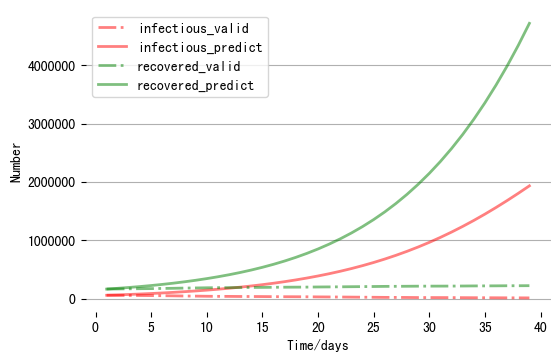

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
# 确定观察的时间周期
T = len(infectious_valid)
# 设置估计疫情的时间跨度为T天
t = np.linspace(1,T,T)
# 估计三种人数的数量
solution = odeint(SIR, y0_valid, t, args = (beta, gamma))
# 绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)
# 绘制估计的I曲线与真实的I曲线
ax.plot(t, infectious_valid, 'r-.', alpha=0.5, lw=2, label='infectious_valid')
ax.plot(t, solution[:,1], 'r', alpha=0.5, lw=2, label='infectious_predict')
# 绘制估计的R曲线与真实的R曲线
ax.plot(t, recovered_valid, 'g-.', alpha=0.5, lw=2, label='recovered_valid')
ax.plot(t, solution[:,2], 'g', alpha=0.5, lw=2, label='recovered_predict')
# 设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
ax.legend()
ax.grid(axis='y')
plt.box(False)

从图中透露出了这样的信息，随着时间的不断延长，预测值与真实值之间的差距也在不断加大。那么究竟是哪里出了问题呢？我们知道，一般疫情爆发时，从爆发开始至疫情发展至中期是人数增长最快的，在这段时间里，政府往往还未来得及做出反应，也没有出台各种有关于防疫的政策措施，所以这段时间里的 β值也应该是最大的。然而，当疫情不断地发展，政府出台了各种防疫措施后， β值就会开始下降。然而我们目前求的是自疫情开始至5月20日的 β值的平均值，所以运用这样估计出的 β值估计后期的发展状态时，感染者会与恢复者的数量就会偏大。

为了方便分析，这里我们将SIR模型封装成一个类。

In [86]:
class SIRModel:
    
    import numpy as np
    from scipy.integrate import odeint
    
    def __init__(self, beta, gamma, method):
        
        self.__beta = beta
        self.__gamma = gamma
        self.__method = method  
        self.__optimal = None
        self.__predict_loss = None

    def sir_model(self, y0, t, beta, gamma):
        
        S, I, R = y0
        dSdt = -beta*S*I/(S+I+R)
        dIdt = beta*S*I/(S+I+R) - gamma*I
        dRdt = gamma*I
        return [dSdt, dIdt, dRdt]
    
    def loss_function(self, params, infected, recovered, y0):
        
        size = len(infected)
        t = np.linspace(1,size,size)
        beta, gamma = params
        solution = odeint(self.sir_model, y0, t, args=(beta, gamma))
        l1 = np.mean((solution[:,1] - infected)**2)
        l2 = np.mean((solution[:,2] - recovered)**2)
        return l1+l2
    
    def fit(self, y0, infected, recovered):

        self.__optimal = minimize(self.loss_function, [self.__beta, self.__gamma],
                                args=(infected, recovered, y0),
                                method=self.__method, 
                                bounds=[(0.00000001, 1), (0.00000001, 1)])
    
    def predict(self, test_y0, days):
        
        
        predict_result = odeint(self.sir_model, test_y0, np.linspace(1,days,days), args=tuple(self.__optimal.x))
        return predict_result
    
    def get_optimal_params(self):
        return self.__optimal.x
    
    def get_predict_loss(self):
        return self.__predict_loss
    
# 模型初始值
def get_init_data(N, I0, R0):
    S0 = N - I0 - R0
    return [S0, I0, R0]    


通过写好的这个类，我们就能在生成模型后直接运用```fit()```方法来训练模型并通过```get_optimal_params()```方法来得到估计的$\beta$和$\gamma$值。

为了获得更好的模型预测效果，我们选从3月8日至4月30日的数据作为训练集，训练模型，并对5月1日至7月15日的疫情进行预测。

In [137]:
italy.set_index('date').loc['2020-03-15']

total_confirm         24938
total_suspect             0
total_heal             2335
total_dead             1809
total_severe              0
total_input               0
today_confirm          3668
today_suspect             0
today_heal              369
today_dead              368
today_severe              0
today_storeConfirm      NaN
today_input               0
name                    意大利
Name: 2020-03-15, dtype: object

In [138]:
# 截取3月8日至3月15日之间的意大利疫情数据
italy_train = italy.set_index('date').loc['2020-03-15':'2020-06-16']
# 确定训练集每天的感染者人数
infectious_train = italy_train['total_confirm'] - italy_train['total_heal'] - italy_train['total_dead']
# 与建立SIR模型时相类似，这里我们也选取每天的康复者和死亡者作为SIR模型的恢复者
recovered_train = italy_train['total_heal'] + italy_train['total_dead']


N = 60000000
I0 = 20794
R0 = 4144
y0 = get_init_data(N, 8514, 1635)

# 建立模型，设定beta gamma初始值，优化方法
model = SIRModel(0.0001, 0.0001, 'L-BFGS-B')

# 训练模型，输入参数：初始值，训练集
model.fit(y0, infectious_train, recovered_train)

# 输出估计最优参数
best_params = model.get_optimal_params()

那么这样我们就对3月8日至3月15日的数据进行了训练，我们输出 β和 γ 的估计值查看与我们之前估计出来的值有什么不同：

In [139]:
best_params

array([0.13513131, 0.11372038])

我们可以看到 β 值由0.23下降到了0.10左右，说明在这段时间内意大利的疫情的感染率正在大幅下降。同时， γ 值也由0.10下降至0.04，说明意大利新冠患者的治愈周期也在延长。这与我们从新闻中获得的信息也是相符的，因为意大利的医疗系统已经饱和，所以更多的病人涌入会导致部分病人都无法得到充足的治疗。

用新估计出的参数值来预测5月1日至7月15日的易感者、感染者和恢复者的数量：

In [140]:
italy.set_index('date').loc['2020-06-17']

total_confirm         237500
total_suspect              0
total_heal            178526
total_dead             34405
total_severe               0
total_input                0
today_confirm            511
today_suspect            NaN
today_heal              2156
today_dead                60
today_severe             NaN
today_storeConfirm       NaN
today_input                0
name                     意大利
Name: 2020-06-17, dtype: object

In [141]:
# 5月1日疫情初值
I0_valid = 24569
R0_valid = 212931
y0_valid = get_init_data(N, I0_valid, R0_valid)
# 预测
predict_result = model.predict(y0_valid,39)

同样我们通过折线图将疫情的预测值和真实值进行对比：

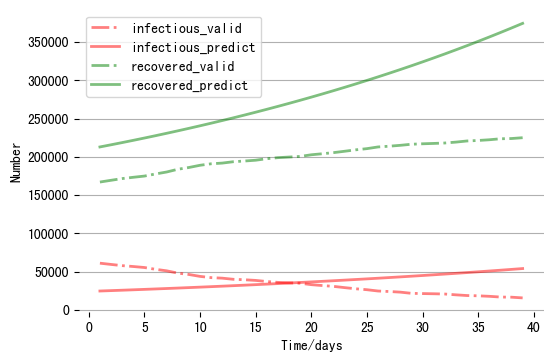

In [142]:
t = np.linspace(1,T,T)
# 绘图
fig, ax = plt.subplots(facecolor='w', dpi=100)
# 绘制估计的I曲线与真实的I曲线
ax.plot(t, infectious_valid, 'r-.', alpha=0.5, lw=2, label='infectious_valid')
ax.plot(t, predict_result[:,1], 'r', alpha=0.5, lw=2, label='infectious_predict')
# 绘制估计的R曲线与真实的R曲线
ax.plot(t, recovered_valid, 'g-.', alpha=0.5, lw=2, label='recovered_valid')
ax.plot(t, predict_result[:,2], 'g', alpha=0.5, lw=2, label='recovered_predict')
# 设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
ax.legend()
ax.grid(axis='y')
plt.box(False)

### 疫情发展趋势预测

下面我们对意大利未来疫情的发展做出预测。我们预测意大利从4月4日至未来两年的疫情。

为了模型有更好的预测效果，我们接着通过3月31日至4月3日的数据训练模型，更新$\beta$和$\gamma$。

In [48]:
italy.set_index('date').loc['2020-03-31']

total_confirm         105792
total_suspect              0
total_heal             15729
total_dead             12428
total_severe               0
total_input                0
today_confirm           4053
today_suspect            NaN
today_heal              1109
today_dead               837
today_severe             NaN
today_storeConfirm       NaN
today_input                0
name                     意大利
Name: 2020-03-31, dtype: object

In [49]:
# 截取3月31日至4月3日之间的意大利疫情数据
italy_train = italy.set_index('date').loc['2020-03-31':'2020-04-03']
# 确定训练集每天的感染者人数
infectious_train = italy_train['total_confirm'] - italy_train['total_heal'] - italy_train['total_dead']
# 与建立SIR模型时相类似，这里我们也选取每天的康复者和死亡者作为SIR模型的恢复者
recovered_train = italy_train['total_heal'] + italy_train['total_dead']

N = 60000000
I0 = 77635
R0 = 28157
y0 = get_init_data(N, I0, R0)

# 建立模型，设定beta gamma初始值，优化方法
new_model = SIRModel(0.0001, 0.0001, 'L-BFGS-B')

# 训练模型，输入参数：初始值，训练集
new_model.fit(y0, infectious_train,recovered_train)

# 输出估计最优参数
best_params = new_model.get_optimal_params()

训练好模型后输出 ββ 和 γγ 的值

In [50]:
best_params

array([0.05810776, 0.02537274])

可以看到意大利新冠疫情的感染率进一步降低了，恢复率几乎与之前保持不变。这说明意大利的医疗从3月8日以来就一直保持饱和状态。

最后我们预测从4月4日至未来两年的疫情：

In [51]:
N = 60000000
I0 = 85388
R0 = 34439
y0_test = get_init_data(N, I0, R0)

# 进行预测
predict_result = new_model.predict(y0_test,730)

得到预测结果后绘图：

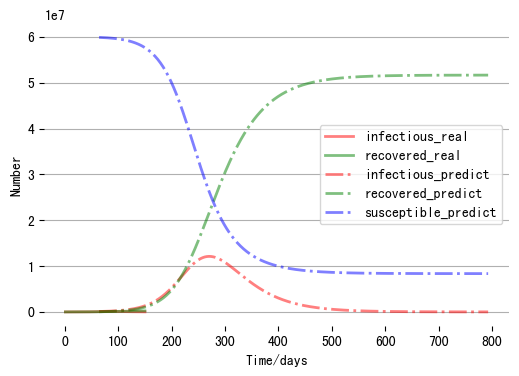

In [52]:
infectious_real = italy['total_confirm'] - italy['total_heal'] - italy['total_dead']
recovered_real = italy['total_heal'] + italy['total_dead']
t = np.linspace(1,len(infectious_real),len(infectious_real))
tpredict = np.linspace(64,793,730)

fig = plt.figure(facecolor='w',dpi=100)
ax = fig.add_subplot(111)
# 绘制真实的I曲线与真实的R曲线
ax.plot(t, infectious_real, 'r', alpha=0.5, lw=2, label='infectious_real')
ax.plot(t, recovered_real, 'g', alpha=0.5, lw=2, label='recovered_real')
# 绘制预测的I曲线、R曲线与S曲线
ax.plot(tpredict, predict_result[:,1], 'r-.', alpha=0.5, lw=2, label='infectious_predict')
ax.plot(tpredict, predict_result[:,2], 'g-.', alpha=0.5, lw=2, label='recovered_predict')
ax.plot(tpredict, predict_result[:,0], 'b-.', alpha=0.5, lw=2, label='susceptible_predict')


# 设置横纵坐标轴
ax.set_xlabel('Time/days')
ax.set_ylabel('Number')
# 添加图例
legend = ax.legend()
ax.grid(axis='y')
plt.box(False)

在本案例建立SIR模型时，我们做了许多的假设。比如，易感者被感染后就会直接发病，中间不会有潜伏期；或者在患者康复后就不会再染病了。我们知道这些假设与实际情形还是有较大差距的。在这次的新冠疫情中，一般患者发病前都会经历一段时间的潜伏期，有时患者被治疗康复后还会再重新被确诊。所以，为了对更复杂的现实情形进行建模，我们就需要用到更复杂的模型。